In [89]:
import numpy as np

import pandas as pd
import scipy.integrate as integrate
from scipy.stats import norm as gaussian

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel,RBF,Matern

import kernels
import utils

import os
import logging
import sys

In [90]:
THRESHOLD = 0.5
W1 = 1
W2 = 20
W3 = 100
W4 = 0.01


def cost_function(true, predicted):
    """
        true: true values in 1D numpy array
        predicted: predicted values in 1D numpy array

        return: float
    """
    cost = (true - predicted)**2

    # true above threshold (case 1)
    mask = true > THRESHOLD
    mask_w1 = np.logical_and(predicted>=true,mask)
    mask_w2 = np.logical_and(np.logical_and(predicted<true,predicted >=THRESHOLD),mask)
    mask_w3 = np.logical_and(predicted<THRESHOLD,mask)

    cost[mask_w1] = cost[mask_w1]*W1
    cost[mask_w2] = cost[mask_w2]*W2
    cost[mask_w3] = cost[mask_w3]*W3

    # true value below threshold (case 2)
    mask = true <= THRESHOLD
    mask_w1 = np.logical_and(predicted>true,mask)
    mask_w2 = np.logical_and(predicted<=true,mask)

    cost[mask_w1] = cost[mask_w1]*W1
    cost[mask_w2] = cost[mask_w2]*W2

    reward = W4*np.logical_and(predicted < THRESHOLD,true<THRESHOLD)
    if reward is None:
        reward = 0
    return np.mean(cost) - np.mean(reward)


"""
Fill in the methods of the Model. Please do not change the given methods for the checker script to work.
You can add new methods, and make changes. The checker script performs:


    M = Model()
    M.fit_model(train_x,train_y)
    prediction = M.predict(test_x)

It uses predictions to compare to the ground truth using the cost_function above.
"""



class Model():
    '''
    Implementation Nystrom from ...
    Implementation FITC from Snelson et al'''
    def __init__(self, model_config_override={}):
        

        """
            TODO: enter your code here
        """
        model_config = {
                "use_skit_learn":False, 
                "use_nystrom":True,
                "use_fitc" : False,
                "nystrom_q":100,
                "kernel":kernels.sklearn_best(),
                "variance":1,
                "correct_y_pred":False,
                "model_preprocess_left_frac":0.75 }
        for k in list(model_config_override.keys()):
            model_config[k] = model_config_override[k]

        self.rbf_w = 1.0
        self.rbf_ls = np.exp(-1.18020928)
        self.wk_nl = np.exp(-5.85276903)

        self.kernel = model_config["kernel"]
        #self.THRESHOLD = THRESHOLD
        self.variance = model_config["variance"]
        self.use_skit_learn = model_config["use_skit_learn"]
        self.use_nystrom = model_config["use_nystrom"]
        self.use_fitc = model_config["use_fitc"]
        self.q = model_config["nystrom_q"]

        self.correct_y_pred = model_config["correct_y_pred"]
        #self.public_score_run = public_score_run
        self.model_preprocess_left_frac = model_config["model_preprocess_left_frac"]

        #"implicit" attributes:
        self.rho = None
        self.correction_obj = None
        self.correction_obj_vals_sample = None
        self.test_x = None
        pass
    
    
    def inverse(self, M):
        if not np.allclose(np.linalg.det(M), 0., atol=1e-5):
            return np.linalg.inv(M)
        else:
            return np.linalg.pinv(M)
        
    def model_preprocess(self,train_x,train_y):
        df_vals = np.stack([train_x[:,0],train_x[:,1],train_y],axis=1)
        #print(df_vals)
        #print(df_vals.shape)
        df = pd.DataFrame(data = df_vals,columns = ['x0','x1','y'])
        #print(df.shape)
        self.df = df 
        
        df_left = df[df['x0']<-0.5]
        df_left = df_left.sample(frac=self.model_preprocess_left_frac,random_state=42)
        df_right = df[df['x0']>-0.5]
        self.df_left = df_left
        self.df_right = df_right

        self.df_left_right = pd.concat([self.df_left,self.df_right])

        train_x = self.df_left_right[['x0','x1']].values
        train_y = self.df_left_right['y'].values
        return train_x,train_y

    def correction_obj_integrand(self,y1,y2): # Remark, the 2 functions below can be fused as one
        return cost_function(np.array([y1]),np.array([y2]))*self.rho(y1)
    
    def correction_obj(self,y2,y1_bounds):
        res = integrate.quad(
                lambda y1: self.correction_obj_integrand(y1,y2),
                -np.inf,np.inf)
        return res[0]

    def correct_y(self,y_mean,y_std):
        self.rho = gaussian(loc=y_mean,scale=y_std).pdf
        test_bounds = [y_mean-2*y_std,y_mean+2*y_std]
        test_points = np.linspace(test_bounds[0],test_bounds[1],100)
        correction_obj_vals = np.array([self.correction_obj(tp,test_bounds)\
                for tp in test_points])
        self.correction_obj_vals_sample = correction_obj_vals
        y_mean_corrected = test_points[np.argmin(correction_obj_vals)]
        return y_mean_corrected


    def predict(self, test_x):
        """
            Uses either our implementation our the skitlearn model
            TODO: enter your code here
        """
        self.test_x = test_x  
        
        ### Get prediction
        if self.use_skit_learn:
            y = self.fitted.predict(self.test_x)
        elif self.use_fitc:
            K_q_star = self.kernel(self.z, self.test_x)
            K_star_star = self.kernel(self.test_x, self.test_x)
            Qn_star = np.dot(self.K_qn.T, np.dot(self.K_qq_inv, K_q_star))

            means = K_q_star.T.dot(self.Q_inv.dot(self.K_qn.dot(self.A_inv.dot(self.train_y))))
            cov = K_star_star - K_q_star.T.dot(self.K_qq_inv - self.Q_inv).dot(K_q_star) 
            vars_val = np.diag(cov)
            y = (np.random.multivariate_normal(means.ravel(), cov, 1)).flatten() #sample from the multivar normal
            logging.info(str(y.shape))

        else: 
            K_star_x = self.kernel(self.test_x, self.train_x)
            K_x_star = self.kernel(self.train_x, self.test_x)
            K_star_star = self.kernel(self.test_x, self.test_x)
            means = K_star_x.dot(self.K_x_x_inv).dot(self.train_y)
            cov = K_star_star - K_star_x.dot(self.K_x_x_inv).dot(K_x_star)
            cov = (cov+cov.transpose())/2
            vars_val = np.diag(cov)
            #print(means)
            #print(cov)
            y = (np.random.multivariate_normal(means.ravel(), cov, 1)).flatten() #sample from the multivar normal
            #print(y.shape)
            logging.info(str(y.shape))
            #print(y)
        
        ### Correct prediction
        if self.correct_y_pred:
        #y_correction vectorization in dev
            y_mean_corrected = np.array([])
            for i in range(0,len(self.test_x)):
                y_mean_corrected = np.append(y_mean_corrected,self.correct_y(y_mean,y_std))
            return y_mean_corrected

        y = np.clip(y,a_min=0,a_max=1)
        y = np.sqrt(y)
        return y

    def fit_model(self, train_x, train_y):
        """
             TODO: enter your code here
        """
        logging_setup()
        
        ### Preprocess 
        if self.model_preprocess_left_frac<0.99:
            self.train_x,self.train_y = self.model_preprocess(train_x,train_y)
        else:
            self.train_x = train_x
            self.train_y = train_y
        
        self.n = np.shape(self.train_x)[0]
        
        ### Preform fit
        if self.use_skit_learn:
            self.gpr = GaussianProcessRegressor(kernel=self.kernel,copy_X_train=False,random_state=42)
            self.fitted = self.gpr.fit( self.train_x , self.train_y)
        elif self.use_nystrom:
            logging.info("Using Nystrom")
            K_nq = self.kernel(self.train_x,self.train_x[:self.q])
            K_qq = self.kernel(self.train_x[:self.q],self.train_x[:self.q])
            K_qq_eigendec = np.linalg.eig(K_qq)
            Lambda_qq = np.diag(K_qq_eigendec[0])
            U_qq = K_qq_eigendec[1]

            #For the minor components- U_qq contains some complex columns
            #if we don't do PCA
            p = utils.pca_find_p(K_qq_eigendec[0],pca_thresh=(1-1e-2))
            self.K_qq_eigendec = K_qq_eigendec
            self.p = p
            Lambda_pp = np.diag(K_qq_eigendec[0][:p+1])
            U_qp = U_qq[:,:p+1]

            Q = K_nq.dot(U_qp).dot(np.sqrt(np.linalg.inv(Lambda_pp)))
            self.U_qp = U_qp
            self.K_nq = K_nq
            self.Lambda_pp = Lambda_pp

            self.Q = Q

            #reduced_inv = np.linalg.inv( self.variance*np.eye(self.q)+(Q.transpose()).dot(Q) )
            reduced_inv = np.linalg.inv( self.variance*np.eye(Q.shape[1])+(Q.transpose()).dot(Q) )
            self.K_x_x_inv = (1/self.variance)*np.eye(self.n) - \
                    (1/self.variance)*Q.dot(reduced_inv).dot(Q.transpose()).real
            
        elif self.use_fitc:
            logging.info("Using FITC")
            self.z = train_x[np.random.choice(train_x.shape[0], 100, replace=False), :]

            K_qq = self.kernel(self.z, self.z)
            self.K_qn = self.kernel(self.z, self.train_x)
            self.Knn = self.kernel(self.train_x, self.train_x)
            self.K_qq_inv = self.inverse(K_qq)
            self.KK = np.dot(self.K_qn.T, np.dot(self.K_qq_inv, self.K_qn))
            Lambda = self.Knn - self.KK 
            self.A = np.diag(np.diag( Lambda + self.variance * np.eye(*self.Knn.shape)))
            self.A_inv = self.inverse(self.A)
            self.Q_inv = self.inverse(K_qq + np.dot(self.K_qn, np.dot(self.A_inv, self.K_qn.T)))

        else:
            self.K_x_x = self.kernel(self.train_x, self.train_x)
            self.K_x_x_inv = np.linalg.inv(self.K_x_x +
                                               (self.variance * np.eye(*self.K_x_x.shape)))
        
    def likelihood(self):
        if self.use_skit_learn:
            log_likelihood = self.gpr.log_marginal_likelihood()
            
        elif self.use_fitc:
            log_likelihood = (-0.5 * np.log(np.linalg.det(self.KK + self.A))
                             -0.5 * self.train_y.T.dot(self.inverse(self.KK + self.A)).dot(self.train_y)
                             -0.5 * len(self.train_y) * np.log(2*np.pi))
        else:
            log_likelihood = (-0.5 * np.dot(self.train_y.T, np.dot(self.K_x_x_inv, self.train_y))
                     -0.5 * np.log(np.linalg.det(self.K_x_x+np.eye(*self.K_x_x.shape)))
                     -0.5 * self.train_y.shape[0] * np.log(2*np.pi))
        return log_likelihood


class cv_eval():
    def __init__(self,
            cv_splits,
            cv_preprocess_left_frac,
            model_config):
        self.K_cv = cv_splits
        #self.model = Model(use_skit_learn, kernel=kernel, preprocess_frac=1.0)
        self.model = Model(model_config)
        self.cv_preprocess_left_frac = cv_preprocess_left_frac #run speed O(N^3)? Can set 0.01 for testing purposes
        self.model_config = model_config
    
    def preprocess(self, train_x, train_y):
        df_vals = np.stack([train_x[:,0],train_x[:,1],train_y],axis=1)
        #print(df_vals)
        #print(df_vals.shape)
        df = pd.DataFrame(data = df_vals,columns = ['x0','x1','y'])
        print(df.shape)
        self.df = df 
        
        df_left = df[df['x0']<-0.5]
        df_left = df_left.sample(frac=self.cv_preprocess_left_frac,random_state=42)
        df_right = df[df['x0']>-0.5]
        self.df_left = df_left
        self.df_right = df_right
    
    def get_split(self, i):
        ''' i index of the CV split'''
        print("i=%d"%i)
        df_train_list = [self.df_left]
        df_right_shuffle = self.df_right.sample(frac=1,random_state=42)
        df_right_splits = np.array_split(df_right_shuffle,self.K_cv)
        for j in range(0,self.K_cv):
            if j!=i:
                df_train_list.append(df_right_splits[j])
        #print(len(df_train_list))
        df_train = pd.concat(df_train_list)
        df_val = df_right_splits[i]

        self.X_train = df_train[['x0','x1']].values
        self.y_train = df_train['y'].values
        self.X_val = df_val[['x0','x1']].values
        self.y_val = df_val['y'].values
    
    def run_cross_validation(self, train_x, train_y):
        if self.cv_preprocess_left_frac < 0.999:
            self.preprocess(train_x, train_y)
        val_cost_array = np.array([])
        marg_log_likelihood_array = np.array([])
        self.models = []
        for i in range(0,self.K_cv):
            self.get_split(i)
            self.model.fit_model(self.X_train, self.y_train)
            if self.model_config["use_skit_learn"]:
                self.models.append(self.model.fitted)
           # print("training gpr score %f"%(gpr.score(X_train,y_train)))

            y_train_pred = self.model.predict(self.X_train)
            #print(np.shape(y_train_pred))
            print("training cost fn   %f"%(cost_function(self.y_train,y_train_pred)))
            
            y_val_pred = self.model.predict(self.X_val)
            #print(y_val_pred)
            #print(np.shape(y_val_pred))
            
            val_llikelihood = self.model.likelihood()
            val_cost = cost_function(self.y_val,y_val_pred)
            print("val cost fn        %f"%(val_cost))
            print("val log likelihood fn        %f"%(val_llikelihood))
            val_cost_array = np.append(val_cost_array,val_cost)
            marg_log_likelihood_array = np.append(marg_log_likelihood_array,val_llikelihood)
            print("\n")
            
        print(marg_log_likelihood_array)
        return val_cost_array



def main():
    train_x_name = "train_x.csv"
    train_y_name = "train_y.csv"

    train_x = np.loadtxt(train_x_name, delimiter=',')
    train_y = np.loadtxt(train_y_name, delimiter=',')

    # load the test dateset
    test_x_name = "test_x.csv"
    test_x = np.loadtxt(test_x_name, delimiter=',')

    M = Model()
    M.fit_model(train_x, train_y)
    prediction = M.predict(test_x)

    print(prediction)



In [91]:
def logging_setup():
    print("logging_setup")
    project_dir = os.path.dirname('/Users/laurieprelot/Documents/Projects/2020_probabilistic_AI/task1_handout/data/log_file')
    logging_path = os.path.join(*[project_dir,'train.log'])
    logging.basicConfig(filename=logging_path, filemode='a',\
            format='%(asctime)s - %(name)s - %(message)s', level=logging.INFO)
    logging.info("Begin logging for single training run")
    root = logging.getLogger()
    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    root.addHandler(handler)

In [92]:
#def main():
train_x_name = "train_x.csv"
train_y_name = "train_y.csv"

train_x = np.loadtxt(train_x_name, delimiter=',')
train_y = np.loadtxt(train_y_name, delimiter=',')

# load the test dateset
test_x_name = "test_x.csv"
test_x = np.loadtxt(test_x_name, delimiter=',')

In [94]:
### TODO add a simple outer train, test split to select the hyperparameters (kernel type etc) in the inner CV loop 
kernel = kernels.sklearn_best()
K_cv = 10
model_config = {
    "kernel":kernel,
    "use_skit_learn":False,
    "use_nystrom":False,
    "use_fitc":True,
    "model_preprocess_left_frac":1.0
}
cv_m = cv_eval(cv_splits = K_cv,
               cv_preprocess_left_frac = 0.05,
               model_config=model_config) # Choose whether to use custom model or scikit learn
val_cost_array = cv_m.run_cross_validation(train_x, train_y)

print(np.mean(val_cost_array))
print(np.std(val_cost_array))

(17250, 3)
i=0
logging_setup
2020-10-11 17:35:57,796 - root - INFO - Begin logging for single training run
2020-10-11 17:35:57,796 - root - INFO - Begin logging for single training run
2020-10-11 17:35:57,796 - root - INFO - Begin logging for single training run
2020-10-11 17:35:57,796 - root - INFO - Begin logging for single training run
2020-10-11 17:35:57,796 - root - INFO - Begin logging for single training run
2020-10-11 17:35:57,796 - root - INFO - Begin logging for single training run
2020-10-11 17:35:57,796 - root - INFO - Begin logging for single training run
2020-10-11 17:35:57,796 - root - INFO - Begin logging for single training run
2020-10-11 17:35:57,796 - root - INFO - Begin logging for single training run
2020-10-11 17:35:57,796 - root - INFO - Begin logging for single training run
2020-10-11 17:35:57,796 - root - INFO - Begin logging for single training run
2020-10-11 17:35:57,796 - root - INFO - Begin logging for single training run
2020-10-11 17:35:57,796 - root - IN

2020-10-11 17:35:57,845 - root - INFO - Using FITC
2020-10-11 17:35:57,845 - root - INFO - Using FITC
2020-10-11 17:35:58,400 - root - INFO - (990,)
2020-10-11 17:35:58,400 - root - INFO - (990,)
2020-10-11 17:35:58,400 - root - INFO - (990,)
2020-10-11 17:35:58,400 - root - INFO - (990,)
2020-10-11 17:35:58,400 - root - INFO - (990,)
2020-10-11 17:35:58,400 - root - INFO - (990,)
2020-10-11 17:35:58,400 - root - INFO - (990,)
2020-10-11 17:35:58,400 - root - INFO - (990,)
2020-10-11 17:35:58,400 - root - INFO - (990,)
2020-10-11 17:35:58,400 - root - INFO - (990,)
2020-10-11 17:35:58,400 - root - INFO - (990,)
2020-10-11 17:35:58,400 - root - INFO - (990,)
2020-10-11 17:35:58,400 - root - INFO - (990,)
2020-10-11 17:35:58,400 - root - INFO - (990,)
2020-10-11 17:35:58,400 - root - INFO - (990,)
2020-10-11 17:35:58,400 - root - INFO - (990,)
2020-10-11 17:35:58,400 - root - INFO - (990,)
2020-10-11 17:35:58,400 - root - INFO - (990,)
2020-10-11 17:35:58,400 - root - INFO - (990,)
2020-

2020-10-11 17:35:58,572 - root - INFO - Begin logging for single training run
2020-10-11 17:35:58,572 - root - INFO - Begin logging for single training run
2020-10-11 17:35:58,572 - root - INFO - Begin logging for single training run
2020-10-11 17:35:58,572 - root - INFO - Begin logging for single training run
2020-10-11 17:35:58,572 - root - INFO - Begin logging for single training run
2020-10-11 17:35:58,572 - root - INFO - Begin logging for single training run
2020-10-11 17:35:58,572 - root - INFO - Begin logging for single training run
2020-10-11 17:35:58,572 - root - INFO - Begin logging for single training run
2020-10-11 17:35:58,572 - root - INFO - Begin logging for single training run
2020-10-11 17:35:58,572 - root - INFO - Begin logging for single training run
2020-10-11 17:35:58,572 - root - INFO - Begin logging for single training run
2020-10-11 17:35:58,572 - root - INFO - Begin logging for single training run
2020-10-11 17:35:58,572 - root - INFO - Begin logging for single

2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17:35:59,142 - root - INFO - (990,)
2020-10-11 17

2020-10-11 17:35:59,334 - root - INFO - Begin logging for single training run
2020-10-11 17:35:59,334 - root - INFO - Begin logging for single training run
2020-10-11 17:35:59,334 - root - INFO - Begin logging for single training run
2020-10-11 17:35:59,334 - root - INFO - Begin logging for single training run
2020-10-11 17:35:59,334 - root - INFO - Begin logging for single training run
2020-10-11 17:35:59,334 - root - INFO - Begin logging for single training run
2020-10-11 17:35:59,334 - root - INFO - Begin logging for single training run
2020-10-11 17:35:59,334 - root - INFO - Begin logging for single training run
2020-10-11 17:35:59,334 - root - INFO - Begin logging for single training run
2020-10-11 17:35:59,334 - root - INFO - Begin logging for single training run
2020-10-11 17:35:59,334 - root - INFO - Begin logging for single training run
2020-10-11 17:35:59,334 - root - INFO - Begin logging for single training run
2020-10-11 17:35:59,334 - root - INFO - Begin logging for single

2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - INFO - (15,)
2020-10-11 17:36:00,146 - root - I

2020-10-11 17:36:00,406 - root - INFO - Using FITC
2020-10-11 17:36:00,406 - root - INFO - Using FITC
2020-10-11 17:36:00,406 - root - INFO - Using FITC
2020-10-11 17:36:00,406 - root - INFO - Using FITC
2020-10-11 17:36:00,406 - root - INFO - Using FITC
2020-10-11 17:36:00,406 - root - INFO - Using FITC
2020-10-11 17:36:00,406 - root - INFO - Using FITC
2020-10-11 17:36:00,406 - root - INFO - Using FITC
2020-10-11 17:36:00,406 - root - INFO - Using FITC
2020-10-11 17:36:00,406 - root - INFO - Using FITC
2020-10-11 17:36:00,406 - root - INFO - Using FITC
2020-10-11 17:36:00,406 - root - INFO - Using FITC
2020-10-11 17:36:00,406 - root - INFO - Using FITC
2020-10-11 17:36:00,406 - root - INFO - Using FITC
2020-10-11 17:36:00,406 - root - INFO - Using FITC
2020-10-11 17:36:00,406 - root - INFO - Using FITC
2020-10-11 17:36:00,406 - root - INFO - Using FITC
2020-10-11 17:36:00,406 - root - INFO - Using FITC
2020-10-11 17:36:00,406 - root - INFO - Using FITC
2020-10-11 17:36:00,406 - root 

2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - INFO - (15,)
2020-10-11 17:36:01,008 - root - I

2020-10-11 17:36:01,274 - root - INFO - Using FITC
2020-10-11 17:36:01,274 - root - INFO - Using FITC
2020-10-11 17:36:01,274 - root - INFO - Using FITC
2020-10-11 17:36:01,274 - root - INFO - Using FITC
2020-10-11 17:36:01,274 - root - INFO - Using FITC
2020-10-11 17:36:01,274 - root - INFO - Using FITC
2020-10-11 17:36:01,274 - root - INFO - Using FITC
2020-10-11 17:36:01,274 - root - INFO - Using FITC
2020-10-11 17:36:01,274 - root - INFO - Using FITC
2020-10-11 17:36:01,274 - root - INFO - Using FITC
2020-10-11 17:36:01,274 - root - INFO - Using FITC
2020-10-11 17:36:01,274 - root - INFO - Using FITC
2020-10-11 17:36:01,274 - root - INFO - Using FITC
2020-10-11 17:36:01,274 - root - INFO - Using FITC
2020-10-11 17:36:01,274 - root - INFO - Using FITC
2020-10-11 17:36:01,274 - root - INFO - Using FITC
2020-10-11 17:36:01,274 - root - INFO - Using FITC
2020-10-11 17:36:01,274 - root - INFO - Using FITC
2020-10-11 17:36:01,274 - root - INFO - Using FITC
2020-10-11 17:36:01,274 - root 

2020-10-11 17:36:01,947 - root - INFO - (15,)
2020-10-11 17:36:01,947 - root - INFO - (15,)
2020-10-11 17:36:01,947 - root - INFO - (15,)
2020-10-11 17:36:01,947 - root - INFO - (15,)
2020-10-11 17:36:01,947 - root - INFO - (15,)
2020-10-11 17:36:01,947 - root - INFO - (15,)
2020-10-11 17:36:01,947 - root - INFO - (15,)
2020-10-11 17:36:01,947 - root - INFO - (15,)
2020-10-11 17:36:01,947 - root - INFO - (15,)
2020-10-11 17:36:01,947 - root - INFO - (15,)
val cost fn        0.225301
val log likelihood fn        -925.610266


i=5
logging_setup
2020-10-11 17:36:02,076 - root - INFO - Begin logging for single training run
2020-10-11 17:36:02,076 - root - INFO - Begin logging for single training run
2020-10-11 17:36:02,076 - root - INFO - Begin logging for single training run
2020-10-11 17:36:02,076 - root - INFO - Begin logging for single training run
2020-10-11 17:36:02,076 - root - INFO - Begin logging for single training run
2020-10-11 17:36:02,076 - root - INFO - Begin logging for sin

2020-10-11 17:36:02,125 - root - INFO - Using FITC
2020-10-11 17:36:02,125 - root - INFO - Using FITC
2020-10-11 17:36:02,125 - root - INFO - Using FITC
2020-10-11 17:36:02,125 - root - INFO - Using FITC
2020-10-11 17:36:02,125 - root - INFO - Using FITC
2020-10-11 17:36:02,125 - root - INFO - Using FITC
2020-10-11 17:36:02,125 - root - INFO - Using FITC
2020-10-11 17:36:02,125 - root - INFO - Using FITC
2020-10-11 17:36:02,125 - root - INFO - Using FITC
2020-10-11 17:36:02,125 - root - INFO - Using FITC
2020-10-11 17:36:02,125 - root - INFO - Using FITC
2020-10-11 17:36:02,125 - root - INFO - Using FITC
2020-10-11 17:36:02,125 - root - INFO - Using FITC
2020-10-11 17:36:02,125 - root - INFO - Using FITC
2020-10-11 17:36:02,125 - root - INFO - Using FITC
2020-10-11 17:36:02,125 - root - INFO - Using FITC
2020-10-11 17:36:02,125 - root - INFO - Using FITC
2020-10-11 17:36:02,125 - root - INFO - Using FITC
2020-10-11 17:36:02,125 - root - INFO - Using FITC
2020-10-11 17:36:02,125 - root 

2020-10-11 17:36:03,113 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,113 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,113 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,113 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,113 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,113 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,113 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,113 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,113 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,113 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,113 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,113 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,113 - root - INFO - Begin logging for single

2020-10-11 17:36:03,157 - root - INFO - Using FITC
2020-10-11 17:36:03,157 - root - INFO - Using FITC
2020-10-11 17:36:03,157 - root - INFO - Using FITC
2020-10-11 17:36:03,157 - root - INFO - Using FITC
2020-10-11 17:36:03,157 - root - INFO - Using FITC
2020-10-11 17:36:03,157 - root - INFO - Using FITC
2020-10-11 17:36:03,157 - root - INFO - Using FITC
2020-10-11 17:36:03,157 - root - INFO - Using FITC
2020-10-11 17:36:03,157 - root - INFO - Using FITC
2020-10-11 17:36:03,157 - root - INFO - Using FITC
2020-10-11 17:36:03,157 - root - INFO - Using FITC
2020-10-11 17:36:03,681 - root - INFO - (990,)
2020-10-11 17:36:03,681 - root - INFO - (990,)
2020-10-11 17:36:03,681 - root - INFO - (990,)
2020-10-11 17:36:03,681 - root - INFO - (990,)
2020-10-11 17:36:03,681 - root - INFO - (990,)
2020-10-11 17:36:03,681 - root - INFO - (990,)
2020-10-11 17:36:03,681 - root - INFO - (990,)
2020-10-11 17:36:03,681 - root - INFO - (990,)
2020-10-11 17:36:03,681 - root - INFO - (990,)
2020-10-11 17:36

2020-10-11 17:36:03,931 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,931 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,931 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,931 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,931 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,931 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,931 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,931 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,931 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,931 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,931 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,931 - root - INFO - Begin logging for single training run
2020-10-11 17:36:03,931 - root - INFO - Begin logging for single

2020-10-11 17:36:03,975 - root - INFO - Using FITC
2020-10-11 17:36:04,739 - root - INFO - (990,)
2020-10-11 17:36:04,739 - root - INFO - (990,)
2020-10-11 17:36:04,739 - root - INFO - (990,)
2020-10-11 17:36:04,739 - root - INFO - (990,)
2020-10-11 17:36:04,739 - root - INFO - (990,)
2020-10-11 17:36:04,739 - root - INFO - (990,)
2020-10-11 17:36:04,739 - root - INFO - (990,)
2020-10-11 17:36:04,739 - root - INFO - (990,)
2020-10-11 17:36:04,739 - root - INFO - (990,)
2020-10-11 17:36:04,739 - root - INFO - (990,)
2020-10-11 17:36:04,739 - root - INFO - (990,)
2020-10-11 17:36:04,739 - root - INFO - (990,)
2020-10-11 17:36:04,739 - root - INFO - (990,)
2020-10-11 17:36:04,739 - root - INFO - (990,)
2020-10-11 17:36:04,739 - root - INFO - (990,)
2020-10-11 17:36:04,739 - root - INFO - (990,)
2020-10-11 17:36:04,739 - root - INFO - (990,)
2020-10-11 17:36:04,739 - root - INFO - (990,)
2020-10-11 17:36:04,739 - root - INFO - (990,)
2020-10-11 17:36:04,739 - root - INFO - (990,)
2020-10-1

2020-10-11 17:36:04,909 - root - INFO - Begin logging for single training run
2020-10-11 17:36:04,909 - root - INFO - Begin logging for single training run
2020-10-11 17:36:04,909 - root - INFO - Begin logging for single training run
2020-10-11 17:36:04,909 - root - INFO - Begin logging for single training run
2020-10-11 17:36:04,909 - root - INFO - Begin logging for single training run
2020-10-11 17:36:04,909 - root - INFO - Begin logging for single training run
2020-10-11 17:36:04,909 - root - INFO - Begin logging for single training run
2020-10-11 17:36:04,909 - root - INFO - Begin logging for single training run
2020-10-11 17:36:04,909 - root - INFO - Begin logging for single training run
2020-10-11 17:36:04,909 - root - INFO - Begin logging for single training run
2020-10-11 17:36:04,909 - root - INFO - Begin logging for single training run
2020-10-11 17:36:04,909 - root - INFO - Begin logging for single training run
2020-10-11 17:36:04,909 - root - INFO - Begin logging for single

2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17:36:05,561 - root - INFO - (990,)
2020-10-11 17

2020-10-11 17:36:05,844 - root - INFO - Begin logging for single training run
2020-10-11 17:36:05,844 - root - INFO - Begin logging for single training run
2020-10-11 17:36:05,844 - root - INFO - Begin logging for single training run
2020-10-11 17:36:05,844 - root - INFO - Begin logging for single training run
2020-10-11 17:36:05,844 - root - INFO - Begin logging for single training run
2020-10-11 17:36:05,844 - root - INFO - Begin logging for single training run
2020-10-11 17:36:05,844 - root - INFO - Begin logging for single training run
2020-10-11 17:36:05,844 - root - INFO - Begin logging for single training run
2020-10-11 17:36:05,844 - root - INFO - Begin logging for single training run
2020-10-11 17:36:05,844 - root - INFO - Begin logging for single training run
2020-10-11 17:36:05,844 - root - INFO - Begin logging for single training run
2020-10-11 17:36:05,844 - root - INFO - Begin logging for single training run
2020-10-11 17:36:05,844 - root - INFO - Begin logging for single

2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17:36:06,655 - root - INFO - (990,)
2020-10-11 17

In [82]:
list(val_cost_array)

[0.07209992137619008,
 0.17445270377886699,
 0.10846403990583242,
 0.39148616309303214,
 0.10342836927574632,
 0.19168100390953782,
 0.3482581224027428,
 0.1630545967466641,
 0.12074886435696518,
 0.09584702689337354]

In [35]:
import matplotlib.pyplot as plt

In [83]:
val_cost_array

array([0.07209992, 0.1744527 , 0.10846404, 0.39148616, 0.10342837,
       0.191681  , 0.34825812, 0.1630546 , 0.12074886, 0.09584703])

In [51]:
llik = [-925.45461515, -925.48659544, -925.47697107, -925.39960863, -925.4639933,
 -925.4439413 , -925.4853168 , -925.43392199 , -925.39372476, -925.46755107]

In [52]:
llik

[-925.45461515,
 -925.48659544,
 -925.47697107,
 -925.39960863,
 -925.4639933,
 -925.4439413,
 -925.4853168,
 -925.43392199,
 -925.39372476,
 -925.46755107]

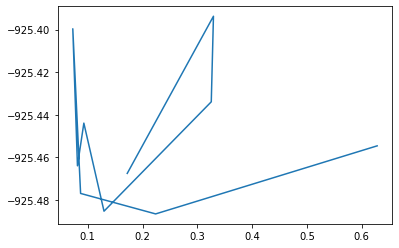

In [54]:
plt.plot(list(val_cost_array),llik )